<a href="https://colab.research.google.com/github/vikhegde/useful-colab-notebooks/blob/main/cats_vs_dogs_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow_datasets as tf_datasets

In [2]:
(raw_train, raw_validation, raw_test), metadata = tf_datasets.load('cats_vs_dogs',
                                                                   split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                                  with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9T2R4W/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
num_examples = metadata.splits["train"].num_examples
num_classes = metadata.features["label"].num_classes
print(f"Number of examples: {num_examples}")
print(f"Number of classes: {num_classes}")

Number of examples: 23262
Number of classes: 2


In [4]:
def normalize_image(image, label):
  image = tf.image.resize(image, (224,224))/255
  return image, label

In [5]:
BATCH_SIZE = 32
train_data = raw_train.shuffle(num_examples//4).map(normalize_image).batch(BATCH_SIZE).prefetch(1)
validation_data = raw_validation.map(normalize_image).batch(BATCH_SIZE).prefetch(1)
test_data = raw_test.map(normalize_image).batch(1)

In [6]:
pretrained_model_name = "mobilenet_v2"
pretrained_feature_extractor = tf_hub.KerasLayer(f"https://tfhub.dev/google/tf2-preview/{pretrained_model_name}/feature_vector/4",
                                input_shape=(224,224,3),
                                output_shape=[1280],
                                trainable=False)
model = tf.keras.Sequential([pretrained_feature_extractor, tf.keras.layers.Dense(num_classes, activation='softmax')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [8]:
NUM_EPOCHS=5
hist = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=validation_data)

Epoch 1/5
582/582 [==============================] - 41s 49ms/step - loss: 0.0962 - accuracy: 0.9639 - val_loss: 0.0372 - val_accuracy: 0.9867
Epoch 2/5
582/582 [==============================] - 31s 47ms/step - loss: 0.0338 - accuracy: 0.9881 - val_loss: 0.0401 - val_accuracy: 0.9867
Epoch 3/5
582/582 [==============================] - 31s 47ms/step - loss: 0.0269 - accuracy: 0.9908 - val_loss: 0.0381 - val_accuracy: 0.9875
Epoch 4/5
582/582 [==============================] - 31s 47ms/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0.0403 - val_accuracy: 0.9888
Epoch 5/5
582/582 [==============================] - 31s 47ms/step - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.0408 - val_accuracy: 0.9871


In [9]:
model_dir = "cats_vs_dogs_model"
tf.saved_model.save(model, model_dir)

INFO:tensorflow:Assets written to: cats_vs_dogs_model/assets


INFO:tensorflow:Assets written to: cats_vs_dogs_model/assets


In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
import pathlib
lite_model_dir = pathlib.Path("/tmp/")
lite_model_path = lite_model_dir/"model1.tflite"
lite_model_path.write_bytes(tflite_model)

8857848

In [17]:
interpreter = tf.lite.Interpreter(model_path="/tmp/model1.tflite")
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
import tqdm
predictions = []
test_images = []
test_labels = []
num_test = 100
for img, label in tqdm.tqdm(test_data.take(num_test)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  test_images.append(img)
  test_labels.append(label.numpy()[0])

100%|██████████| 100/100 [00:02<00:00, 44.41it/s]


In [20]:
import numpy as np
correct = 0
for i in range(num_test):
  if test_labels[i] == np.argmax(predictions[i]):
    correct += 1
print(f"Got {correct} correct predictions and {num_test-correct} wrong predictions") 

Got 99 correct predictions and 1 wrong predictions


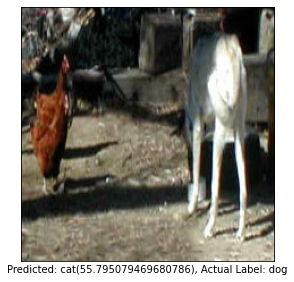

In [29]:
import matplotlib.pyplot as plt
class_names = ["cat", "dog"]
def plot_image(predictions, image, label):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = np.squeeze(image)
  predicted_proba = np.max(predictions) * 100
  predicted_label = class_names[np.argmax(predictions)]
  plt.imshow(img)
  plt.xlabel(f"Predicted: {predicted_label}({predicted_proba}), Actual Label: {class_names[label]}")


for i in range(num_test):
  pred = predictions[i]
  image = test_images[i]
  label = test_labels[i]
  if np.argmax(pred) == label:
    continue
  plt.figure(figsize = (10, 10))
  plt.subplot(1,2,1)
  plot_image(pred, image, label)
  plt.show() 

In [ ]:
""